# Проект "Маркетинг"

**Описание проекта:**

Интернет-магазин собирает историю покупателей, проводит рассылки предложений и планирует будущие продажи.
Для оптимизации процессов необходимо выделить пользователей, которые готовы совершить покупку в ближайшее время.

Для решения задачи предстоит выполнить инжиниринг признаков, обучить и оптимизировать модель бинарной классификации, которая предскажет вероятность совершения покупки пользователем в течение 90 дней (бинарный таргет).

 **Результат:**

  - прогноз вероятности покупки в течение 90 дней пользователем;
  - ключевая метрика ROC-AUC (>= 0.7).

Для работы предоставлены 3 датасета с исходными данными и 2 датасета со сводной статистикой на базе исходных данных.

## Загрузка требуемых библиотек

In [1]:
# стандартные библиотеки
import os
from datetime import datetime, timedelta
import ast
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import phik
import seaborn as sns
from tqdm import tqdm

# импорт scikit-learn
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, auc, confusion_matrix, precision_score, 
    recall_score, roc_auc_score, roc_curve, RocCurveDisplay
)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    LabelEncoder,
    MinMaxScaler,
    OneHotEncoder, 
    StandardScaler,
    TargetEncoder
)
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor

# библиотеки для дисбаланса
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.under_sampling import TomekLinks

# бустинг LightGBM
from lightgbm import LGBMClassifier

In [2]:
# настройка формата вывода float в таблицах
pd.set_option('display.float_format', '{:,.2f}'.format)

In [3]:
# фиксируем случайность
RANDOM_STATE = 12345

## Загрузка данных

### Датасет 'apparel-purchases.csv'

In [4]:
purchases_data = pd.read_csv(os.path.join('data', 'apparel-purchases.csv'), parse_dates=['date'])
purchases_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202208 entries, 0 to 202207
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   client_id     202208 non-null  int64         
 1   quantity      202208 non-null  int64         
 2   price         202208 non-null  float64       
 3   category_ids  202208 non-null  object        
 4   date          202208 non-null  datetime64[ns]
 5   message_id    202208 non-null  object        
dtypes: datetime64[ns](1), float64(1), int64(2), object(2)
memory usage: 9.3+ MB


Данные успешно загружены. Датасет содержит информацию о покупках клиентов, содержит 202208 записей и 6 признаков. Пропущенных значений нет.

### Датасет: 'apparel-messages.csv'

In [5]:
messages_data = pd.read_csv(os.path.join('data', 'apparel-messages.csv'), parse_dates=['date', 'created_at'])
messages_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12739798 entries, 0 to 12739797
Data columns (total 7 columns):
 #   Column            Dtype         
---  ------            -----         
 0   bulk_campaign_id  int64         
 1   client_id         int64         
 2   message_id        object        
 3   event             object        
 4   channel           object        
 5   date              datetime64[ns]
 6   created_at        datetime64[ns]
dtypes: datetime64[ns](2), int64(2), object(3)
memory usage: 680.4+ MB


In [6]:
# Анализ пропущенных значений:
for col in messages_data.columns:
    print(f"{col}: {messages_data[col].isna().sum()}")

bulk_campaign_id: 0
client_id: 0
message_id: 0
event: 0
channel: 0
date: 0
created_at: 0


Данные успешно загружены. Датасет содержит информацию о рассылках которые были направлены клиентам. Датасет содержит более 12 млн записей и 7 признаков. Пропущенных значений нет.

### Датасет 'apparel-target_binary.csv'

In [7]:
target_binary = pd.read_csv(os.path.join('data', 'apparel-target_binary.csv'))
target_binary.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49849 entries, 0 to 49848
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   client_id  49849 non-null  int64
 1   target     49849 non-null  int64
dtypes: int64(2)
memory usage: 779.0 KB


In [8]:
target_binary.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


Данные успешно загружены. Датасет содержит значение бинарного таргета. Таргетом является вероятность совершения покупки пользователем в течение 90 дней.

### Выводы

Предоставлено 3 датасета. Данные успешно загружены. Пропущенные значения не обнаружены.

## Предобработка данных

### Датасет "purchases_data"

In [9]:
purchases_data.head()

,client_id,quantity,price,category_ids,date,message_id
0,1515915625468169594,1,"1,999.00","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
1,1515915625468169594,1,"2,499.00","['4', '28', '57', '431']",2022-05-16,1515915625468169594-4301-627b661e9736d
2,1515915625471138230,1,"6,499.00","['4', '28', '57', '431']",2022-05-16,1515915625471138230-4437-6282242f27843
3,1515915625471138230,1,"4,999.00","['4', '28', '244', '432']",2022-05-16,1515915625471138230-4437-6282242f27843
4,1515915625471138230,1,"4,999.00","['4', '28', '49', '413']",2022-05-16,1515915625471138230-4437-6282242f27843


 Анализ датасета позволяет сделать следующие заключения:
 - 4 количественных признака (в т.ч. 1 признак времени), 2 категориальных;
 - 'client_id' - индексный признак с точки зрения агрегирования данных для подготовки данных к обучению моделей;
 - 'message_id' - индексный признак для датасета 'messages_data', при этом можно заметить что он состоит из трех частей: "client_id"-"bulk_campaign_id"-"hash";
 - при помощи 'quantity' и 'price' можно вычислить новый признак 'total'
 - 'category_ids' - данные представлены в виде строковых значений, по форме представляют собой список с числами в виде строковых значений.

Проведем предобработку датасета:

In [10]:
# разбиваем message_id на части
split_columns = purchases_data['message_id'].str.split('-', expand=True)

# переименовываем столбцы и преобразуем типы данных
split_columns.columns = ['client_id_mes', 'bulk_campaign_id', 'hash_code']
split_columns['client_id_mes'] = split_columns['client_id_mes'].astype('int64')
split_columns['bulk_campaign_id'] = split_columns['bulk_campaign_id'].astype('int64')

# добавляем новые столбцы в исходный DataFrame
purchases_data = pd.concat([purchases_data, split_columns], axis=1)

# выделим наблюдения с некорректным message_id
purchases_data['client_id_check'] = purchases_data['client_id'] == purchases_data['client_id_mes']

In [11]:
# строим матрицу сопряжения для фиксации наличия ошибок в message_id
confusion_table = target_binary.merge(purchases_data, how='left', on='client_id')
(confusion_table
 .groupby(['client_id_check', 'target'])
 .size()
 .unstack()
 .assign(total=lambda x: x.sum(axis=1))
 .pipe(lambda df: pd.concat([
     df,
     df.div(df['total'], axis=0).drop('total', axis=1).add_prefix('perc_')
 ], axis=1)))

target,0,1,total,perc_0,perc_1
client_id_check,,,,,
False,54138,1545,55683,0.97,0.03
True,141272,5253,146525,0.96,0.04


Как можно заметить часть наблюдений имеет некорректный 'client_id' (или в 'messages_id' или в признаке 'client_id') что указывает на то что в данных имеется ошибка. Если это ошибка, а в датасете 'messages_data' данные корректные то такие наблюдения не объединятся при объединении датасетов. Стоит заметить, что доля ошибочных  наблюдений достаточно весома и составляет 27%.

In [12]:
# исключим лишние признаки
purchases_data = purchases_data.drop(['client_id_mes', 'bulk_campaign_id', 'hash_code', 'client_id_check'], axis=1)

# добавим новым признак total
purchases_data['total'] = purchases_data['quantity'] * purchases_data['price']

# преобразуем признак "category_ids" в список и преобразуем элементы списка в числовой формат 
purchases_data['category_ids'] = purchases_data['category_ids'].apply(ast.literal_eval)
purchases_data['category_ids'] = purchases_data['category_ids'].apply(lambda lst: [int(x) for x in lst if x is not None])

# проанализируем длины путей
purchases_data['category_ids'].apply(lambda x: len(x)).value_counts(normalize=True)

4   0.96
0   0.03
3   0.01
5   0.00
Name: category_ids, dtype: float64

Подавляющая часть путей в иерархии товара состоит из 4 уровней (96%), незначительная часть это пустые пути (3%) и 1% это пути состоящие из 3 или 5 уровней.

In [13]:
# добавим новый признак в виде строкового вектора и сжатого строкового вектора
purchases_data['category_ids_str'] = purchases_data['category_ids'].apply(lambda x: '_'.join(map(str, x) if x is not None else None))
purchases_data['category_ids_str_short'] = purchases_data['category_ids'].apply(lambda x: f"{x[0]}_{x[-1]}" if isinstance(x, list) and len(x) > 0 else None)
purchases_data['category_ids_first'] = purchases_data['category_ids'].apply(lambda x: f"{x[0]}" if isinstance(x, list) and len(x) > 0 else None)
purchases_data['category_ids_last'] = purchases_data['category_ids'].apply(lambda x: f"{x[-1]}" if isinstance(x, list) and len(x) > 0 else None)

print(f"category_ids_str: {purchases_data['category_ids_str'].nunique()} уникальных наименований")
print(f"category_ids_str_short: {purchases_data['category_ids_str_short'].nunique()} уникальных наименований")
print(f"category_ids_first: {purchases_data['category_ids_first'].nunique()} уникальных наименований")
print(f"category_ids_last: {purchases_data['category_ids_last'].nunique()} уникальных наименований")
print(purchases_data[['category_ids_str', 'category_ids_str_short', 'category_ids_first', 'category_ids_last']].head())

category_ids_str: 932 уникальных наименований
category_ids_str_short: 891 уникальных наименований
category_ids_first: 8 уникальных наименований
category_ids_last: 842 уникальных наименований
  category_ids_str category_ids_str_short category_ids_first category_ids_last
0      4_28_57_431                  4_431                  4               431
1      4_28_57_431                  4_431                  4               431
2      4_28_57_431                  4_431                  4               431
3     4_28_244_432                  4_432                  4               432
4      4_28_49_413                  4_413                  4               413


Как можно заметить вариация 'category_ids_str_short' практически идентична 'category_ids_str'. Отсюда использование 'category_ids_str_short' не приведет к снижению информативности признака, но позволит удобнее работать с признаком.

Проанализируем распределения признаков датасета:

In [14]:
# распределение количественых признаков
purchases_data.select_dtypes(include=np.number).describe()

,client_id,quantity,price,total
count,"202,208.00","202,208.00","202,208.00","202,208.00"
mean,"1,515,915,625,596,210,944.00",1.01,"1,193.30","1,199.48"
std,"145,945,755.93",0.18,"1,342.25","1,355.02"
min,"1,515,915,625,468,060,928.00",1.00,1.00,1.00
25%,"1,515,915,625,490,081,280.00",1.00,352.00,355.00
50%,"1,515,915,625,557,177,088.00",1.00,987.00,997.00
75%,"1,515,915,625,624,391,936.00",1.00,"1,699.00","1,699.00"
max,"1,515,915,626,010,443,520.00",30.00,"85,499.00","85,499.00"


In [15]:
# распределение временных признаков
purchases_data.select_dtypes(include='datetime').describe(datetime_is_numeric=True)

,date
count,202208
mean,2023-03-17 02:49:35.739832064
min,2022-05-16 00:00:00
25%,2022-11-12 00:00:00
50%,2023-04-12 00:00:00
75%,2023-07-03 00:00:00
max,2024-02-16 00:00:00


Датасет содержит информацию с 16-05-2022 по 16-02-2024. Добавим новый признак: дней с момента последней покупки (recency).

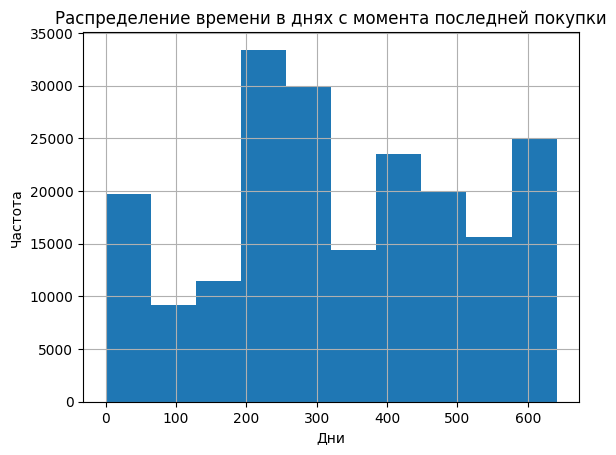

In [16]:
purchases_data['recency_purchase'] = (purchases_data['date'].max() - purchases_data['date']).dt.days
purchases_data['recency_purchase'].hist()
plt.title('Распределение времени в днях с момента последней покупки')
plt.xlabel('Дни')
plt.ylabel('Частота')
plt.show()

Как можно заметить, время последней покупки распределено ненормально и может быть охарактеризовано как мультимодальное.

При проверки наличия явных дубликатов в датасете необходимо учитывать что возможны ситуации что покупатель сделал одинаковые покупки в течение одного дня. Признак 'date' указан в виде даты без указания времени, отсюда ситуации одинаковой покупки в течение одного дня будут классифицированы как явные дубликаты, что очевидно может быть не так. Проверка на дубликаты не возможна и принимаем допущение что дубликатов нет, а проверка была проведена на этапе формирования данных.

### Датасет 'messages_data'

In [17]:
# изучим данные датасета
messages_data.head()

,bulk_campaign_id,client_id,message_id,event,channel,date,created_at
0,4439,1515915625626736623,1515915625626736623-4439-6283415ac07ea,open,email,2022-05-19,2022-05-19 00:14:20
1,4439,1515915625490086521,1515915625490086521-4439-62834150016dd,open,email,2022-05-19,2022-05-19 00:39:34
2,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,open,email,2022-05-19,2022-05-19 00:51:49
3,4439,1515915625553578558,1515915625553578558-4439-6283415b36b4f,click,email,2022-05-19,2022-05-19 00:52:20
4,4439,1515915625471518311,1515915625471518311-4439-628341570c133,open,email,2022-05-19,2022-05-19 00:56:52


 Анализ датасета позволяет сделать следующие заключения:
 - датасет является довольно большим (12.7 млн строк);
 - 4 количественных признака (в т.ч. 2 признака времени), 3 категориальных;
 - 'client_id' - индексный признак с точки зрения агрегирования данных для подготовки данных к обучению моделей;
 - признак 'created_at' дублирует 'date' и отличается наличием времени: можно исключить;
 - 'message_id' - индексный признак для датасета 'purchases_data', выполним проверку по аналогии как с 'message_id' в 'purchases_data'.

In [18]:
# разбиваем message_id на части
split_columns = messages_data['message_id'].str.split('-', expand=True)

# переименовываем столбцы
split_columns.columns = ['client_id_mes', 'bulk_campaign_id_mes', 'hash_code']
split_columns['client_id_mes'] = split_columns['client_id_mes'].astype('int64')
split_columns['bulk_campaign_id_mes'] = split_columns['bulk_campaign_id_mes'].astype('int64')

# добавляем новые столбцы в исходный DataFrame
messages_data = pd.concat([messages_data, split_columns], axis=1)

In [19]:
# проверка совпадения 'client_id'
messages_data['client_id_check'] = messages_data['client_id'] == messages_data['client_id_mes']
(messages_data['client_id_check']).all()

True

In [20]:
# проверка совпадения 'bulk_campaign_id'
(messages_data['bulk_campaign_id'] == messages_data['bulk_campaign_id_mes']).all()

True

Признак 'message_id' в датасете 'mesagges_data' корректен. На этапе предобработки 'purchases_data' мы выявили что 27% данных не совпадают, то потеря этих данных приведет к существенной потере данных. В этой связи на этапе интеграции датасетов необходимо будет решать задачу замены пропусков.

In [21]:
# удалим лишние признаки
messages_data = messages_data.drop(['client_id_mes', 'bulk_campaign_id_mes', 'client_id_check', 'hash_code'], axis=1)

In [22]:
# функция проверки наличия дубликатов
def duplicates_check(data):
    data_shape_pre = data.shape[0]
    duplicates_check = data.duplicated()
    print(f'Исходное кол-во строк датасета: {data_shape_pre}')
    print(f'Количество дубликатов: {duplicates_check.sum()}')
    print(f'Доля дубликатов: {duplicates_check.sum() / data_shape_pre * 100:.2f}%')
    data_adj = data.drop_duplicates()
    print(f'Датасет преобразован (дубликаты удалены).\n')
    return data_adj.reset_index(drop=True)

# удалим явные дубликаты
messages_data = duplicates_check(messages_data)

Исходное кол-во строк датасета: 12739798
Количество дубликатов: 48610
Доля дубликатов: 0.38%
Датасет преобразован (дубликаты удалены).



In [23]:
# исключим признак 'created_at'
messages_data = messages_data.drop('created_at', axis=1)

Проанализируем распределения признаков по типам данных.

In [24]:
# распределение количественых признаков
messages_data.select_dtypes(include=np.number).describe()

,bulk_campaign_id,client_id
count,"12,691,188.00","12,691,188.00"
mean,"11,597.68","1,515,915,625,574,722,048.00"
std,"3,262.18","132,900,789.00"
min,548.00,"1,515,915,625,468,060,928.00"
25%,"8,746.00","1,515,915,625,489,147,648.00"
50%,"13,516.00","1,515,915,625,503,393,792.00"
75%,"14,158.00","1,515,915,625,591,285,504.00"
max,"14,657.00","1,515,915,626,010,288,640.00"


In [25]:
# распределение временных признаков
messages_data.select_dtypes(include='datetime').describe(datetime_is_numeric=True)

,date
count,12691188
mean,2023-06-04 17:27:00.569989632
min,2022-05-19 00:00:00
25%,2022-12-16 00:00:00
50%,2023-07-20 00:00:00
75%,2023-11-21 00:00:00
max,2024-02-15 00:00:00


Датасет содержит информацию с 19-05-2022 по 15-02-2024.

In [26]:
# распределение категориальных признаков
messages_data.select_dtypes(include='object').describe().T

,count,unique,top,freq
message_id,12691188,9061667,1515915625489095763-6251-6311b13a4cf78,1427
event,12691188,11,send,9058174
channel,12691188,2,mobile_push,7470472


In [27]:
# количество событий
counts = messages_data['event'].value_counts()

# Считаем доли (проценты от общего числа)
percentages = messages_data['event'].value_counts(normalize=True).mul(100).round(2)

# Объединяем в один DataFrame
result = pd.DataFrame({
    'Количество': counts,
    'Доля (%)': percentages,
    'Доля (%) накопленно': percentages.cumsum()
})

# Сортируем по убыванию (опционально)
result = result.sort_values('Количество', ascending=False)

print(result)

             Количество  Доля (%)  Доля (%) накопленно
send            9058174     71.37                71.37
open            3052481     24.05                95.42
click            483326      3.81                99.23
purchase          62593      0.49                99.72
hard_bounce       19763      0.16                99.88
soft_bounce       10582      0.08                99.96
unsubscribe        2833      0.02                99.98
hbq_spam            823      0.01                99.99
complain            527      0.00                99.99
subscribe            85      0.00                99.99
close                 1      0.00                99.99


Признак 'event' содержит 11 уникальных значения. Последующая аггрегация признака может привести к потере вариации признаки. Можно заметить, что подавляющее большинство значений это ['send', 'open', 'click', 'purchase'] остальные значения в сумме составляют менее 1.0%. Для предотвращения потери информации при группировки датасетов необходимо осуществить векторизацию признака по типам значений, при этом незначительные категории целесообразно объединить в одну категорию 'other'. 

In [28]:
# cписок основных событий
main_events = ['send', 'open', 'click', 'purchase']

# заменяем остальные на 'other'
messages_event_arr = np.where(messages_data['event'].isin(main_events), messages_data['event'], 'other')
all_categories = main_events + ['other']

# создаем и настраиваем OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, categories=[all_categories], handle_unknown='ignore')

# преобразуем массив и применяем OHE
event_data = messages_event_arr.reshape(-1, 1)
event_encoded = encoder.fit_transform(event_data)

# добавляем event в исходный датасет
event_encoded_df = pd.DataFrame(event_encoded, columns=[f'event_{cat}' for cat in all_categories])

# объединяем датасеты
messages_data = pd.concat([messages_data, event_encoded_df], axis=1)
messages_data = messages_data.drop('event', axis=1)

In [29]:
# уникальные значения channel
messages_data['channel'].unique().tolist()

['email', 'mobile_push']

In [30]:
# количество событий
counts = messages_data['channel'].value_counts()

# Считаем доли (проценты от общего числа)
percentages = messages_data['channel'].value_counts(normalize=True).mul(100).round(2)

# Объединяем в один DataFrame
result = pd.DataFrame({
    'Количество': counts,
    'Доля (%)': percentages,
    'Доля накопленно (%)': percentages.cumsum()
})

result = result.sort_values('Количество', ascending=False)

print(result)

             Количество  Доля (%)  Доля накопленно (%)
mobile_push     7470472     58.86                58.86
email           5220716     41.14               100.00


In [31]:
# определяем основные категории
main_channels = ['email', 'mobile_push']

# фильтруем данные 
filtered_data = messages_data[messages_data['channel'].isin(main_channels)].copy()

# создаем и настраиваем OneHotEncoder
encoder = OneHotEncoder(sparse_output=False, categories=[main_channels], handle_unknown='ignore')

# преобразуем и применяем OHE
channel_encoded = encoder.fit_transform(filtered_data[['channel']])

# добавляем event в исходный датасет
channel_encoded_df = pd.DataFrame(channel_encoded, columns=[f'channel_{cat}' for cat in main_channels])
messages_data = pd.concat([messages_data, channel_encoded_df], axis=1)
messages_data = messages_data.drop('channel', axis=1)

### Датасет "target_binary"

In [32]:
target_binary.head()

,client_id,target
0,1515915625468060902,0
1,1515915625468061003,1
2,1515915625468061099,0
3,1515915625468061100,0
4,1515915625468061170,0


In [33]:
target_binary.describe()

,client_id,target
count,"49,849.00","49,849.00"
mean,"1,515,915,625,598,796,032.00",0.02
std,"148,794,654.89",0.14
min,"1,515,915,625,468,060,928.00",0.00
25%,"1,515,915,625,489,972,736.00",0.00
50%,"1,515,915,625,556,614,912.00",0.00
75%,"1,515,915,625,633,408,768.00",0.00
max,"1,515,915,626,010,443,520.00",1.00


In [34]:
target_binary = target_binary.set_index('client_id')
target_binary.value_counts(normalize=True)

target
0        0.98
1        0.02
dtype: float64

Только 2% пользователей готовы совершить покупку в течение 90 дней. Низкое значение положительного значения таргета указывает на существенный дисбаланс класса '1' в общей выборке. Данное обстоятельство потребует решать задачу борьбы с дисбалансом на этапе подготовки данных для обучения модели.

### Выводы

Данные датасетов проанализированы. Проведена предобработка признаков, уникальные значения проанализированы. Осуществлена предобработка данных. Добавлены дополнительные признаки.

## Исследовательский анализ данных

Таргет является бинарным значением проиндексированным по признаку 'client_id', отсюда для подготовки данных для обучения модели имеющиеся признаки должны быть агрегированы и сгруппированы по каждому клиенту ('client_id'). Для решения данной задачи необходимо осуществить слияние и группировку датасетов 'purchases_data' и 'messages_data', а затем расчитать признаки и только после этого объединить с таргетом.

### Анализ признаков и объединение датасетов

Имеющиеся данные по клиентам размещены в двух датасетах: purcshases_data и messages_data. В рамках загрузки и предобработки были выявлены общие признаки по которым можно произвести объединение этих данных ('client_id' и 'message_id'). Проанализируем пересечение индексных признаков.

In [35]:
message_client_ids = set(messages_data['client_id'].values)
purchase_client_ids = set(purchases_data['client_id'].values)
all_ = message_client_ids.symmetric_difference(purchase_client_ids)
purch_ = purchase_client_ids.difference(message_client_ids)
mess_ = message_client_ids.difference(purchase_client_ids)
print(f'Всего не совпадающих клиентов: {len(all_)}, в т.ч.:')
print(f' - покупатели без сообщений: {len(purch_)}')
print(f' - сообщения без покупателей: {len(mess_)}')

Всего не совпадающих клиентов: 19214, в т.ч.:
 - покупатели без сообщений: 7867
 - сообщения без покупателей: 11347


Объединим датасеты покупок и рассылок 

Датасет 'purchases_data' содержит 7867 покупателей без данных из 'messages_data'. При этом 'messages_data' содержит 11347 клиентов которые отсутствуют в 'purchases_data'. Для дальнейшего анализа необходимо объединить датасеты и обработать пропущенные значения. Для заполнения пропущенных значений после объединения датасетов будем использовать модель DecisionTreeClassifier для категориальных признаков и DecisionTreeRegressor для количественных признаков.

In [36]:
# объединим датасеты покупки и сообщений
joined_data = purchases_data.merge(messages_data, how='left', on=['client_id', 'message_id'])

# заполним пропущенные значения 'date' в 'purchases_data' значениями 'messages_data' 
joined_data['date_y'] = joined_data['date_y'].fillna(joined_data['date_x'])

In [37]:
# функция замены пропущенных значений для категориальных признаков
def decision_tree_cat_imputer(data: pd.DataFrame, target: str, tree_depth=10) -> pd.Series:
 
    # копируем данные
    df = data.copy()

    # Разделяем данные на обучающую и тестовую выборки
    train_df = df[df[target].notna()]
    test_df = df[df[target].isna()]
    
    # определяем признаки, исключая сложные типы данных
    def is_simple_type(x):
        return isinstance(x, (str, int, float, type(None)))
    
    cat_cols = []
    for col in df.select_dtypes(include=['object']).columns:
        if col != target and df[col].apply(is_simple_type).all():
            cat_cols.append(col)
    
    num_cols = [col for col in df.select_dtypes(include=['number']).columns 
               if col != target]
    
    # если нет категориальных признаков, используем только числовые
    if not cat_cols:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', SimpleImputer(strategy='mean'), num_cols)
            ],
            remainder='drop'
        )
    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                ('num', SimpleImputer(strategy='mean'), num_cols)
            ],
            remainder='drop'
        )
    
    # кодируем целевой признак
    try:
        target_encoder = LabelEncoder()
        y_train = target_encoder.fit_transform(train_df[target].astype(str))
    except Exception as e:
        print(f"Ошибка при кодировании целевого признака {target}: {e}")
        return pd.Series(dtype=object)
    
    # преобразуем признаки
    try:
        X_train = preprocessor.fit_transform(train_df)
        X_test = preprocessor.transform(test_df)
    except Exception as e:
        print(f"Ошибка при преобразовании признаков для {target}: {e}")
        return pd.Series(dtype=object)
    
    # обучаем модель и делаем предсказания
    try:
        clf = DecisionTreeClassifier(max_depth=tree_depth, random_state=RANDOM_STATE)
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        predict_labels = target_encoder.inverse_transform(y_pred)
    except Exception as e:
        print(f"Ошибка при обучении модели для {target}: {e}")
        return pd.Series(dtype=object)
    
    return pd.Series(predict_labels, index=test_df.index)

In [38]:
# функция замены пропущенных значений для количественных признаков
def decision_tree_num_imputer(data: pd.DataFrame, target: str, tree_depth=20) -> pd.Series:

    # копируем данные
    df = data.copy()
    
    # разделяем данные на обучающую и тестовую выборки
    train_df = df[df[target].notna()]
    test_df = df[df[target].isna()]
    
    # определяем признаки, исключая сложные типы данных
    def is_simple_type(x):
        return isinstance(x, (str, int, float, type(None)))
    
    cat_cols = []
    for col in df.select_dtypes(include=['object']).columns:
        if col != target and df[col].apply(is_simple_type).all():
            cat_cols.append(col)
    
    num_cols = [col for col in df.select_dtypes(include=['number']).columns 
               if col != target]
    
    # если нет категориальных признаков, используем только числовые
    if not cat_cols:
        preprocessor = ColumnTransformer(
            transformers=[
                ('num', SimpleImputer(strategy='mean'), num_cols)
            ],
            remainder='drop'
        )
    else:
        preprocessor = ColumnTransformer(
            transformers=[
                ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
                ('num', SimpleImputer(strategy='mean'), num_cols)
            ],
            remainder='drop'
        )
    
    # преобразуем признаки
    try:
        X_train = preprocessor.fit_transform(train_df)
        y_train = train_df[target].values
        X_test = preprocessor.transform(test_df)
    except Exception as e:
        print(f"Ошибка при преобразовании признаков для {target}: {e}")
        return pd.Series(dtype=float)
    
    # обучаем модель и делаем предсказания
    try:
        reg = DecisionTreeRegressor(max_depth=tree_depth, random_state=RANDOM_STATE)
        reg.fit(X_train, y_train)
        y_pred = reg.predict(X_test)
    except Exception as e:
        print(f"Ошибка при обучении модели для {target}: {e}")
        return pd.Series(dtype=float)
    
    return pd.Series(y_pred, index=test_df.index)

In [39]:
print('Количество пропущенных значений:')
missed_data_cols = []
for col in joined_data.columns:
    na = sum(joined_data[col].isna())
    if na > 0:
        missed_data_cols.append(col)
        print(f" * {col}: {na} ({na / len(joined_data[col]) * 100:.2f}%)")

Количество пропущенных значений:
 * category_ids_str_short: 24669 (2.94%)
 * category_ids_first: 24669 (2.94%)
 * category_ids_last: 24669 (2.94%)
 * bulk_campaign_id: 56428 (6.74%)
 * event_send: 56428 (6.74%)
 * event_open: 56428 (6.74%)
 * event_click: 56428 (6.74%)
 * event_purchase: 56428 (6.74%)
 * event_other: 56428 (6.74%)
 * channel_email: 56428 (6.74%)
 * channel_mobile_push: 56428 (6.74%)


In [40]:
# формируем списки признаков по типам
cat_cols = joined_data.select_dtypes(include='object').columns.to_list()
num_cols = joined_data.select_dtypes(include='number').columns.to_list()
cat_cols_missed = list(set(missed_data_cols) - set(num_cols))
num_cols_missed = list(set(missed_data_cols) - set(cat_cols))

In [41]:
# заполняем пропуски в количественных признаках
for col in tqdm(num_cols_missed, desc='Обработка количественных признаков'):
        pred_series = decision_tree_num_imputer(joined_data, col, 20)
        joined_data.loc[pred_series.index, col] = pred_series
        print(f'Обработан {col}')

# заполняем пропуски в категориальных признаках
for col in tqdm(cat_cols_missed, desc='Обработка категориальных признаков'):
        pred_series = decision_tree_cat_imputer(joined_data, col, 20)
        joined_data.loc[pred_series.index, col] = pred_series
        print(f'Обработан {col}')

Обработка количественных признаков:  12%|█▎        | 1/8 [00:04<00:32,  4.66s/it]

Обработан event_send


Обработка количественных признаков:  25%|██▌       | 2/8 [00:08<00:25,  4.17s/it]

Обработан channel_email


Обработка количественных признаков:  38%|███▊      | 3/8 [00:21<00:41,  8.21s/it]

Обработан event_other


Обработка количественных признаков:  50%|█████     | 4/8 [00:25<00:26,  6.74s/it]

Обработан event_purchase


Обработка количественных признаков:  62%|██████▎   | 5/8 [00:45<00:34, 11.39s/it]

Обработан bulk_campaign_id


Обработка количественных признаков:  75%|███████▌  | 6/8 [00:50<00:18,  9.13s/it]

Обработан event_click


Обработка количественных признаков:  88%|████████▊ | 7/8 [00:54<00:07,  7.65s/it]

Обработан event_open


Обработка количественных признаков: 100%|██████████| 8/8 [00:58<00:00,  7.36s/it]


Обработан channel_mobile_push


Обработка категориальных признаков:  33%|███▎      | 1/3 [00:12<00:25, 12.54s/it]

Обработан category_ids_first


Обработка категориальных признаков:  67%|██████▋   | 2/3 [00:26<00:13, 13.25s/it]

Обработан category_ids_last


Обработка категориальных признаков: 100%|██████████| 3/3 [00:39<00:00, 13.28s/it]

Обработан category_ids_str_short


In [42]:
joined_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 837739 entries, 0 to 837738
Data columns (total 21 columns):
 #   Column                  Non-Null Count   Dtype         
---  ------                  --------------   -----         
 0   client_id               837739 non-null  int64         
 1   quantity                837739 non-null  int64         
 2   price                   837739 non-null  float64       
 3   category_ids            837739 non-null  object        
 4   date_x                  837739 non-null  datetime64[ns]
 5   message_id              837739 non-null  object        
 6   total                   837739 non-null  float64       
 7   category_ids_str        837739 non-null  object        
 8   category_ids_str_short  837739 non-null  object        
 9   category_ids_first      837739 non-null  object        
 10  category_ids_last       837739 non-null  object        
 11  recency_purchase        837739 non-null  int64         
 12  bulk_campaign_id        837739

Полученный датасет содержит 782824 строки и 15 признаков.

In [43]:
def get_mode(series):
    modes = series.mode()
    return modes[0] if not modes.empty else np.nan

# Преобразуем числовые колонки, где есть запятые в качестве разделителей тысяч
numeric_cols = ['total', 'price', 'recency_purchase', 'event_send', 'event_open', 
                'event_click', 'event_purchase', 'event_other', 'channel_email', 
                'channel_mobile_push', 'bulk_campaign_id']

for col in numeric_cols:
    if col in joined_data.columns:
        joined_data[col] = joined_data[col].astype(str).str.replace(',', '').astype(float)

# Расчет агрегированных метрик
grouped_data = joined_data.groupby('client_id').agg(
    total_sum=('total', 'sum'),
    total_count=('total', 'count'),
    total_mean=('total', 'mean'),
    total_std=('total', 'std'),
    total_max=('total', 'max'),
    total_min=('total', 'min'),
    
    price_mean=('price', 'mean'),
    price_std=('price', 'std'),
    
    quantity_sum=('quantity', 'sum'),
    quantity_mean=('quantity', 'mean'),
    quantity_std=('quantity', 'std'),
    
    category_unique=('category_ids_str', 'nunique'),
    category_moda=('category_ids_str', get_mode),
    
    event_send_count=('event_send', 'sum'),
    event_open_count=('event_open', 'sum'),
    event_click_count=('event_click', 'sum'),
    event_purchase_count=('event_purchase', 'sum'),
    event_other_count=('event_other', 'sum'),
    
    channel_email_count=('channel_email', 'sum'),
    channel_mobile_push_count=('channel_mobile_push', 'sum'),
    
    bulk_campaign_count=('bulk_campaign_id', 'count'),
    bulk_campaign_unique=('bulk_campaign_id', 'nunique'),
    
    message_unique=('message_id', 'nunique'),
    
    date_purchase_min=('date_x', 'min'),
    date_purchase_max=('date_x', 'max'),
    date_purchase_unique=('date_x', 'nunique'),
    
    recency_purchase_mean=('recency_purchase', 'mean'),
    recency_purchase_max=('recency_purchase', 'max'),
    recency_purchase_min=('recency_purchase', 'min')
).reset_index()

In [44]:
# перенесем 'client_id' в индекс 
data_features_full = grouped_data.set_index('client_id')

# объединим таргет и сгруппированные признаки
data_features_full = target_binary.merge(data_features_full, how='left', on='client_id')

# исключаем пропущенные значения
data_features_full = data_features_full.dropna()
print(data_features_full.info())

# проанализируем полученный датасет
data_features_full.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47537 entries, 1515915625468060902 to 1515915626010439406
Data columns (total 30 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   target                     47537 non-null  int64         
 1   total_sum                  47537 non-null  float64       
 2   total_count                47537 non-null  int64         
 3   total_mean                 47537 non-null  float64       
 4   total_std                  47537 non-null  float64       
 5   total_max                  47537 non-null  float64       
 6   total_min                  47537 non-null  float64       
 7   price_mean                 47537 non-null  float64       
 8   price_std                  47537 non-null  float64       
 9   quantity_sum               47537 non-null  int64         
 10  quantity_mean              47537 non-null  float64       
 11  quantity_std               47537 no

,target,total_sum,total_count,total_mean,total_std,total_max,total_min,price_mean,price_std,quantity_sum,...,channel_mobile_push_count,bulk_campaign_count,bulk_campaign_unique,message_unique,date_purchase_min,date_purchase_max,date_purchase_unique,recency_purchase_mean,recency_purchase_max,recency_purchase_min
client_id,,,,,,,,,,,,,,,,,,,,,
1515915625468060902,0,"76,923.00",77,999.00,747.45,"1,999.00",199.00,999.00,747.45,77,...,0.00,77,1,1,2022-05-27,2022-05-27,1,630.00,630.00,630.00
1515915625468061003,1,"64,940.00",28,"2,319.29",528.44,"3,499.00","1,749.00","2,319.29",528.44,28,...,0.00,28,1,1,2023-01-04,2023-01-04,1,408.00,408.00,408.00
1515915625468061100,0,"8,392.00",8,"1,049.00",0.00,"1,049.00","1,049.00","1,049.00",0.00,8,...,8.00,8,1,1,2024-02-10,2024-02-10,1,6.00,6.00,6.00
1515915625468061170,0,"147,643.00",85,"1,736.98",902.17,"2,699.00",7.00,"1,736.98",902.17,85,...,0.00,85,3,3,2023-03-26,2023-06-17,3,316.52,327.00,244.00
1515915625468061514,0,"3,996.00",4,999.00,0.00,999.00,999.00,999.00,0.00,4,...,0.00,4,1,1,2022-07-30,2022-07-30,1,566.00,566.00,566.00


Добавим новые признаки:

In [45]:
# RFM (Recency, Frequency, Monetary)
scaler = MinMaxScaler()
rfm_features = ['recency_purchase_min', 'total_count', 'total_sum']
data_features_full['RFM_Score'] = pd.DataFrame(
    scaler.fit_transform(data_features_full[rfm_features]),
    columns=rfm_features, index=data_features_full.index
).sum(axis=1)

# период активности клиента (в днях)
grouped_data['customer_lifetime_days'] = (grouped_data['date_purchase_max'] - grouped_data['date_purchase_min']).dt.days

# Purchase Frequency Rate
data_features_full['purchase_frequency'] = (
    data_features_full['total_count'] / 
    (data_features_full['date_purchase_max'] - data_features_full['date_purchase_min']).dt.days.clip(lower=1)
)

# коэффициент вариации суммы покупок
grouped_data['total_coef_var'] = grouped_data['total_std'] / grouped_data['total_mean']

# коэффициент категорийной диверсификация
data_features_full['Category_Diversity'] = (
    data_features_full['category_unique'] / 
    data_features_full['total_count'].replace(0, 1)
)

# коэффициент вовлеченности
data_features_full['engagement_score'] = (
    (data_features_full['event_send_count'] + data_features_full['channel_email_count']) / 
    data_features_full['total_count'].replace(0, 1)
)

# коэффициент конверсации кликов
data_features_full['conversion_after_click'] = (
    data_features_full['event_purchase_count'] / data_features_full['event_click_count']
    ).replace(0, 1)

# коэффициент уровня отклика
data_features_full['response_rate'] = (
    data_features_full['total_count'] / 
    data_features_full['event_send_count'].replace(0, 1)
)

# коэффициент цикла покупок
data_features_full['purchase_cycle'] = (
    (data_features_full['date_purchase_max'] - data_features_full['date_purchase_min']).dt.days / 
    data_features_full['total_count'].replace(0, 1)
)

# дней с последней покупки
data_features_full['days_since_last_purchase'] = (
    datetime.today().date() - data_features_full['date_purchase_max'].dt.date
    ).dt.days

# cредний интервал между покупками
grouped_data['avg_purchase_interval'] = grouped_data['customer_lifetime_days'] / grouped_data['total_count']

# коэффициент отношения максимальной покупки к средней
data_features_full['high_value_ratio'] = (
    data_features_full['total_max'] / data_features_full['total_mean']
    ).fillna(0)

# эффективность каналов коммуникации
grouped_data['email_effectiveness'] = grouped_data['event_click_count'] / grouped_data['channel_email_count'].replace(0, 1)
grouped_data['push_effectiveness'] = grouped_data['event_click_count'] / grouped_data['channel_mobile_push_count'].replace(0, 1)

# коэффициент стабильности покупок
grouped_data['purchase_stability'] = grouped_data['date_purchase_unique'] / grouped_data['customer_lifetime_days'].replace(0, 1)

### Анализ важности признаков

Для оценки важности признаков будем использовать модель RandomForestClassifier.

In [111]:
# подготовка данных
X = data_features_full.drop(columns=['target'])
y = data_features_full['target']

# преобразование datetime в числовой формат
datetime_cols = X.select_dtypes(include=['datetime64']).columns
for col in datetime_cols:
    X[col] = X[col].astype('int64')

# Очистка от inf и больших значений
X = X.replace([np.inf, -np.inf], np.nan).fillna(0)

# кодируем категориальные признаки
categorical_cols = X.select_dtypes(include=['object', 'category']).columns
for col in categorical_cols:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))

# разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# обучение модели случайного леса
rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=5,
    random_state=42,
    class_weight='balanced'
)
rf.fit(X_train, y_train)

# получение важности признаков
importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("Важные признаки:")
importance = importance.reset_index(drop=True)
importance.index = importance.index + 1
print(importance)

print("\nСтатистика по важности:")
print(importance['importance'].describe())


Важные признаки:
                      feature  importance
1           date_purchase_max        0.08
2              purchase_cycle        0.08
3    days_since_last_purchase        0.07
4                   RFM_Score        0.07
5              message_unique        0.07
6        recency_purchase_min        0.07
7        bulk_campaign_unique        0.06
8        date_purchase_unique        0.05
9                  total_mean        0.04
10                  total_min        0.04
11         purchase_frequency        0.03
12          date_purchase_min        0.03
13      recency_purchase_mean        0.03
14       recency_purchase_max        0.03
15                 price_mean        0.03
16           high_value_ratio        0.03
17                  total_max        0.02
18                  total_sum        0.02
19                total_count        0.02
20               quantity_sum        0.02
21                  total_std        0.02
22           event_send_count        0.01
23        bulk_ca

Выполним обработку признаков и исключим признаки со степенью важности ниже медианной важности.

In [ ]:
# исключим бесполезные признаки
importance = importance[importance['importance'] > importance['importance'].quantile(0.50)]
important_features = importance['feature'].tolist()
data_features_adj = data_features_full[important_features + ['target']]

## Корреляционный анализ

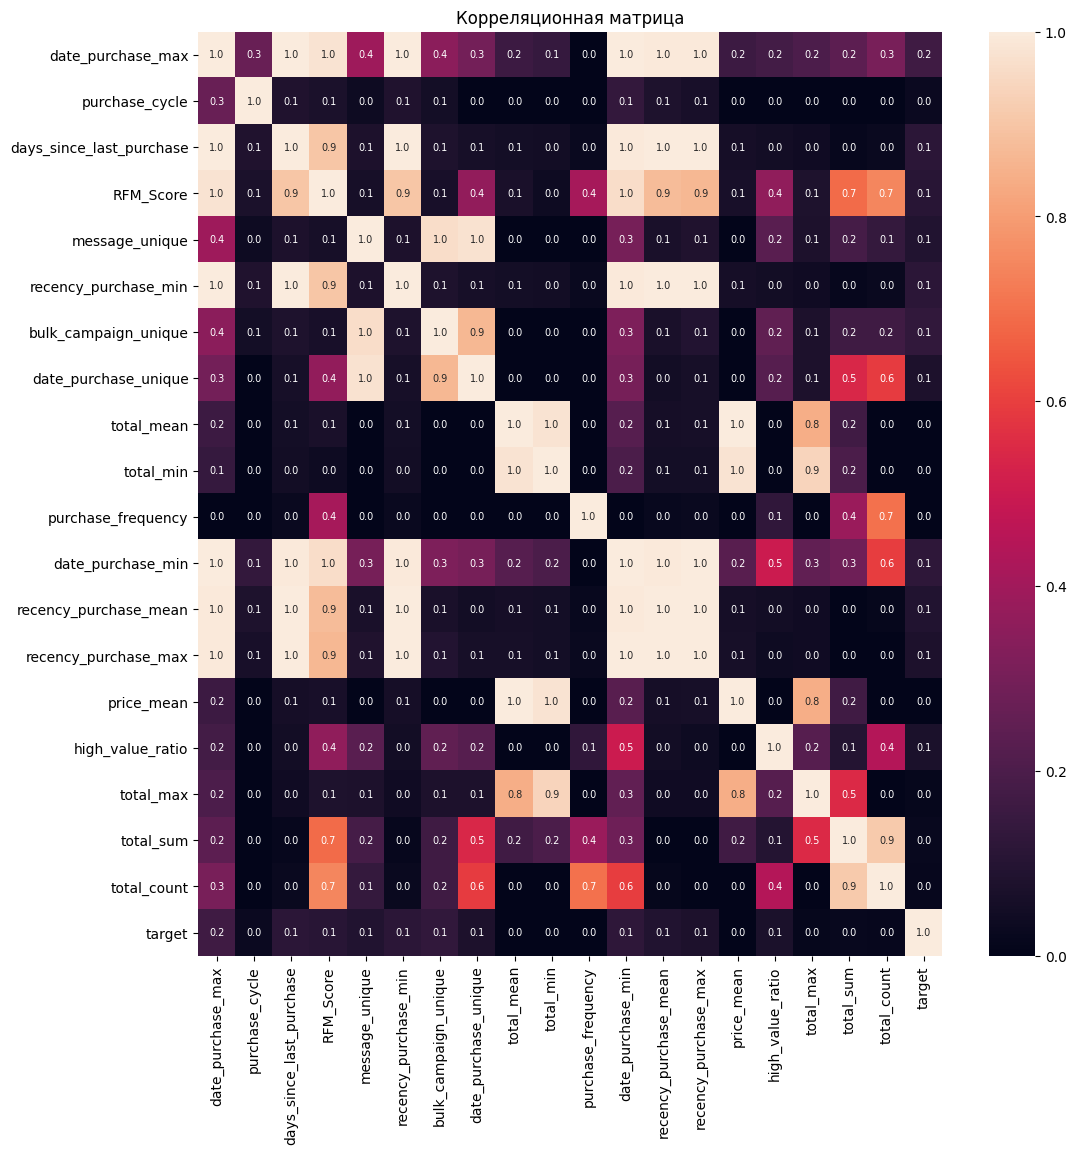

In [113]:
# рассчитаем корреляции признаков
num_cols = data_features_adj.select_dtypes(include='number').columns.to_list()
corr_matrix = data_features_adj.phik_matrix(interval_cols=num_cols)
corr_joined_data = pd.DataFrame(corr_matrix, index = data_features_adj.columns, columns=data_features_adj.columns)
ax, fig = plt.subplots(figsize=(12, 12))
ax=sns.heatmap(corr_joined_data, annot=True, fmt='.1f', annot_kws={'size': 7})
ax.set_title('Корреляционная матрица')
plt.show()

Анализ корреляционной матрицы позволяет заметить, что среди признаков присутствует мультиколлинеарность:
 - выявлена мультиколлинеарность ряда признаков -> необходимо исключить взаимосвязанные признаки, при этом будем оставлять те у которых сильнее корреляция с таргетом;
 - можно заметить, что не выявлена высокая корреляция  признаков и таргета.

In [114]:
# функция анализа мультиколлинеарных признаков
def find_correlated_features_with_target(corr_matrix, target_name, threshold=0.9):
    
    # Создаем копию матрицы корреляций
    corr = corr_matrix.copy()
    
    # Игнорируем диагональ
    np.fill_diagonal(corr.values, 0)
    
    # Список для хранения признаков к исключению
    to_drop = set()
    
    # Проходим по всем столбцам матрицы корреляций (кроме целевой)
    features = [col for col in corr.columns if col != target_name]
    
    for col in features:
        # Находим признаки с корреляцией выше порога (исключая целевую)
        correlated = [f for f in corr.index[abs(corr[col]) > threshold] 
                    if f != target_name]
        
        # Для каждого коррелированного признака
        for corr_feature in correlated:
            # Выбираем какой признак оставить (с большей корреляцией с таргетом)
            corr_with_target_col = abs(corr.loc[col, target_name])
            corr_with_target_feature = abs(corr.loc[corr_feature, target_name])
            
            if corr_with_target_col > corr_with_target_feature:
                to_drop.add(corr_feature)
            else:
                to_drop.add(col)
    
    return list(to_drop)

In [115]:
features_to_drop = find_correlated_features_with_target(corr_joined_data, 'target')
print('Список признаков для исключения:')
features_to_drop

Список признаков для исключения:


['date_purchase_min',
 'recency_purchase_max',
 'recency_purchase_min',
 'price_mean',
 'total_min',
 'total_count',
 'total_mean',
 'days_since_last_purchase',
 'message_unique',
 'recency_purchase_mean',
 'RFM_Score',
 'date_purchase_unique']

In [116]:
# исключим лишние признаки
data_features_adj = data_features_adj.drop(features_to_drop, axis=1)

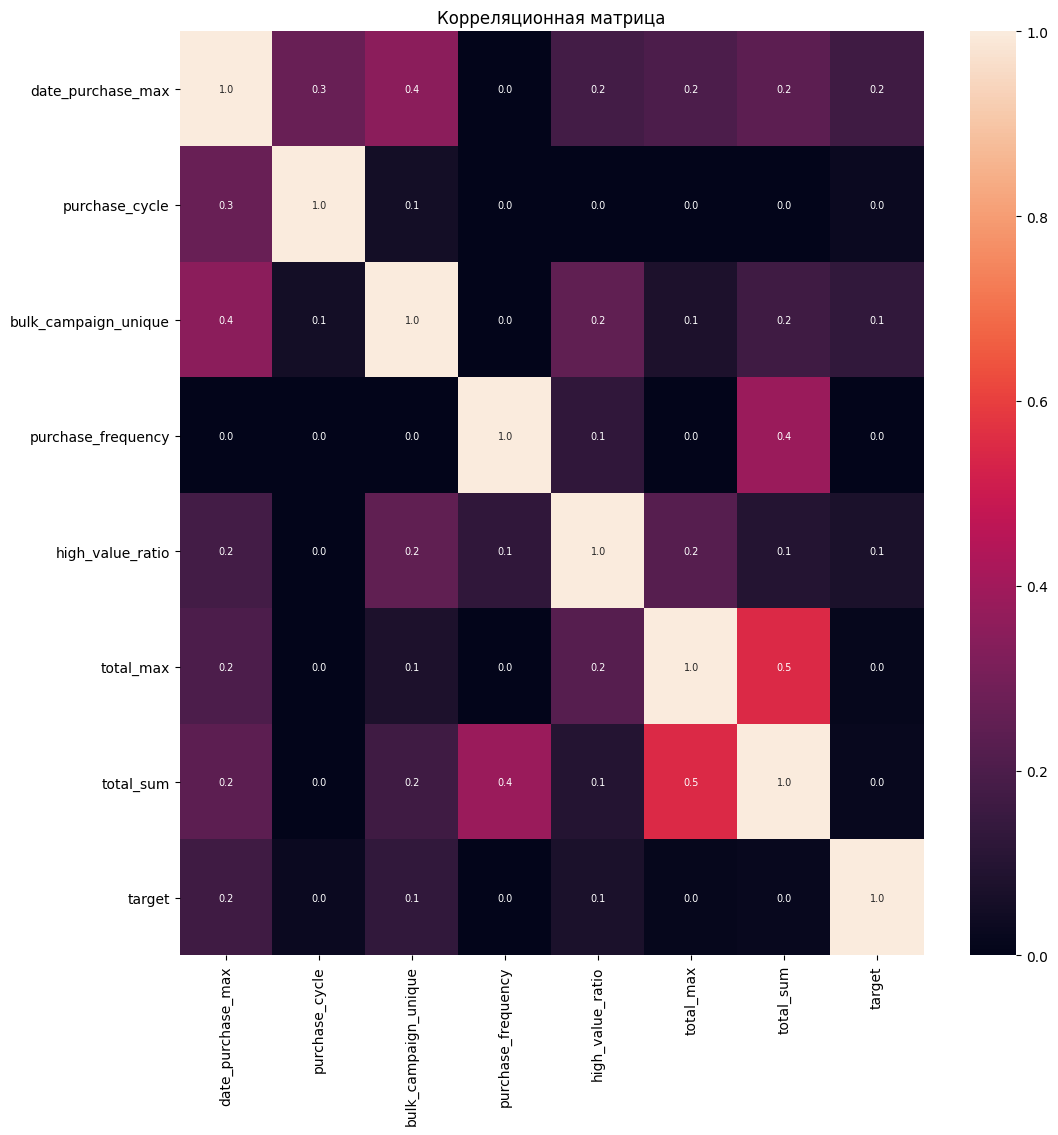

In [117]:
# повторно рассчитаем корреляции признаков
num_cols = data_features_adj.select_dtypes(include='number').columns.to_list()
corr_matrix = data_features_adj.phik_matrix(interval_cols=num_cols)
corr_joined_data = pd.DataFrame(corr_matrix, index = data_features_adj.columns, columns=data_features_adj.columns)
ax, fig = plt.subplots(figsize=(12, 12))
ax=sns.heatmap(corr_joined_data, annot=True, fmt='.1f', annot_kws={'size': 7})
ax.set_title('Корреляционная матрица')
plt.show()

## Обучение моделей

В рамках проекта таргет это бинарный признак, отсюда его прогноз это задача классификации. Ранее было обнаружено что положительный класс таргета имеет существенный дисбаланс и составляет около 2%. Кроме того анализ корреляции не выявил наличия сильной линейной связи таргета и признаков.

Для боробы с дисбалансом таргета будет использована модель синтетической генерации примером минорного класса SMOTE с сэмплированием 0.3, а также модель Tomek Links для удаления шумовых наблюдений на границе классов. 

Низкая корреляция таргета и признаков указывает на нелинейную зависимость, отсюда линейные модели и KNN будут плохо работать. Итоговый перечень моделей следующий:
 - LightGBM (LGBMClassifier);
 - Random Forest (RandomForestClassifier);
 - Логистическая регрессия (LogisticRegression);
 - SVM (SVC).

В качестве целевой метрики будет использован ROC-AUC. Для поиска будет использован случайный поиск с кросс-валидацией.

In [118]:
# скорректируем тип данных datetime в разницу
datetime_cols = data_features_adj.select_dtypes(include=['datetime64']).columns
for col in datetime_cols:
    data_features_adj[col] = (data_features_adj[col] - pd.Timestamp('2000-01-01')).dt.total_seconds()

data_features_adj = data_features_adj.replace([np.inf, -np.inf], np.nan)   

#### Подготовка данных

In [119]:
TEST_SIZE = 0.25

# данные для моделирования
X_train, X_test, y_train, y_test = train_test_split(
    data_features_adj.drop('target', axis=1),
    data_features_adj['target'],
    random_state=RANDOM_STATE,
    test_size=TEST_SIZE,
    stratify=data_features_adj['target']
)

# списки с названиями признаков
num_cols = X_train.select_dtypes(include='number').columns.tolist()
ohe_cols = X_train.select_dtypes(include='object').columns.tolist()

#### Построение пайплайна

In [120]:
from imblearn.under_sampling import TomekLinks, RandomUnderSampler

In [121]:
# создаем пайплайн для подготовки признаков из списка ohe_columns
ohe_pipe = Pipeline(
    [
        ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('target_encoder', TargetEncoder(cv=5, smooth='auto', random_state=RANDOM_STATE))
        #('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False))
    ]
)

num_pipe = Pipeline(
    [
        ('imputer', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
        ('num', StandardScaler())
    ]
)

# создаем общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_cols),
        ('num', num_pipe, num_cols)
    ],
    remainder='passthrough'
)

# создаем итоговый пайплайн 
pipe_final = ImbPipeline(
    [
        ('preprocessor', data_preprocessor),
        ('resampler', SMOTETomek(
            smote=SMOTE(
                sampling_strategy=0.3,
                k_neighbors=3,
                random_state=RANDOM_STATE
            ),
            tomek=TomekLinks(),
            random_state=RANDOM_STATE
        )),
        ('model', LGBMClassifier(
            random_state=RANDOM_STATE,
            class_weight='balanced',
            scale_pos_weight=4
        ))
    ]
)

In [122]:
param_grid = [
    # словарь для LGBM
    {
        'model': [LGBMClassifier(random_state=RANDOM_STATE)],
        'model__boosting_type': ['gbdt'],  # Убрал 'dart', т.к. 'gbdt' стабильнее
        'model__num_leaves': [5, 10, 15, 20],  # Уменьшил для борьбы с переобучением
        'model__learning_rate': [0.01, 0.05, 0.1],
        'model__n_estimators': [100, 200, 500],  # Уменьшил максимальное значение
        'model__min_data_in_leaf': [20, 50, 100],  # Увеличил для устойчивости
        'model__reg_alpha': [0, 0.1, 1],
        'model__reg_lambda': [0, 0.1, 1],
        'model__class_weight': [None],  # 'balanced' менее эффективен, чем scale_pos_weight
        'model__objective': ['binary'],  # Убрал 'cross_entropy', чтобы упростить
        'model__feature_fraction': [0.5, 0.6, 0.7],  # Уменьшил для регуляризации
        'model__bagging_fraction': [0.5, 0.6, 0.7],  # Уменьшил для бэггинга
        'model__bagging_freq': [0, 5, 10],
        'model__scale_pos_weight': [10, 20, 49, 50],  # Оптимальные значения для дисбаланса 2%
        'model__min_child_weight': [1e-2, 0.1, 1],  # Увеличил минимальный вес
    },
    # словарь для RandomForest
    {
        'model': [RandomForestClassifier(random_state=RANDOM_STATE)],
        'model__class_weight': ['balanced', 'balanced_subsample'],  # Добавил 'balanced_subsample'
        'model__n_estimators': [50, 100, 200],  # Уменьшил для скорости
        'model__max_depth': [5, 10, 15],  # Ограничил глубину
        'model__min_samples_leaf': [20, 50, 100],  # Увеличил для устойчивости
        'model__max_features': ['sqrt'],  # Оставил для разнообразия
    },
    # словарь для LogisticRegression
    {
        'model': [LogisticRegression(random_state=RANDOM_STATE)],
        'model__class_weight': ['balanced'],
        'model__penalty': ['l1', 'l2'],
        'model__C': [0.001, 0.01, 0.1, 1],  # Добавил более сильную регуляризацию
        'model__solver': ['liblinear'],  # Убрал 'saga', т.к. 'liblinear' стабильнее для l1
        'model__max_iter': [1000],
    },
    # словарье для SVC
    {
        'model': [SVC(random_state=RANDOM_STATE, probability=True)],
        'model__class_weight': ['balanced'],
        'model__C': [0.01, 0.1, 1],  # Уменьшил C для регуляризации
        'model__kernel': ['linear'],  # Убрал 'rbf', т.к. линейное ядро устойчивее
        'model__gamma': ['scale'],
    }
]

#### Поиск лучшей модели

In [123]:
# поиск лучшей модели
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    n_iter=200,
    scoring=['roc_auc', 'f1', 'accuracy'],
    refit='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=20,
    verbose=0
).fit(X_train, y_train)

result = pd.DataFrame(randomized_search.cv_results_)


c:\Users\den_m\.conda\envs\practicum\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\den_m\.conda\envs\practicum\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
c:\Users\den_m\.conda\envs\practicum\lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 10484, number of

In [127]:
# вывод рейтинга моделей
result_sort = result[
    ['param_model', 'mean_fit_time', 'mean_score_time', 'mean_test_roc_auc', 
     'mean_test_f1', 'mean_test_accuracy',  'rank_test_roc_auc']
].sort_values('rank_test_roc_auc').reset_index(drop=True)

result_sort.index = result_sort.index + 1
print('Рейтинг вариантов моделей по показателю ROC AUC:')
display(result_sort.head(10))

Рейтинг вариантов моделей по показателю ROC AUC:


,param_model,mean_fit_time,mean_score_time,mean_test_roc_auc,mean_test_f1,mean_test_accuracy,rank_test_roc_auc
1,LGBMClassifier(random_state=12345),5.44,0.06,0.69,0.04,0.22,1
2,LGBMClassifier(random_state=12345),4.00,0.05,0.69,0.04,0.22,2
3,LGBMClassifier(random_state=12345),4.94,0.05,0.69,0.05,0.43,3
4,LGBMClassifier(random_state=12345),3.59,0.05,0.69,0.04,0.22,4
5,LGBMClassifier(random_state=12345),12.49,0.07,0.69,0.04,0.09,5
6,LGBMClassifier(random_state=12345),11.86,0.08,0.69,0.04,0.20,6
7,LGBMClassifier(random_state=12345),11.14,0.07,0.69,0.06,0.52,7
8,LGBMClassifier(random_state=12345),4.06,0.05,0.69,0.04,0.23,8
9,LGBMClassifier(random_state=12345),19.99,0.17,0.69,0.04,0.19,9
10,LGBMClassifier(random_state=12345),7.34,0.06,0.69,0.04,0.16,10


In [128]:
# лучшая модель и препроцессор
best_estimator = randomized_search.best_estimator_
print('Гиперпараметры лучшей модели:\n')
print(best_estimator)
best_model_class = best_estimator['model']
final_preprocessor = best_estimator['preprocessor']
X_test_transformed = final_preprocessor.transform(X_test)
y_pred = best_model_class.predict(X_test_transformed)

Гиперпараметры лучшей модели:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('target_encoder',
                                                                   TargetEncoder(random_state=12345))]),
                                                  []),
                                                 ('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('num',
                                                           

c:\Users\den_m\.conda\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


Лучшей моделью оказался классификатор LightGBM (LGBMClassifier). Для борьбы с дисбалансом классов в пайплайне использована комбинация SMOTETomek, включающая синтетическую генерацию примеров миноритарного класса (SMOTE) и очистку данных от шумовых объектов (Tomek Links). Оптимизация гиперпараметров проводилась по метрике ROC-AUC.

Категориальные признаки обрабатывались в два этапа: сначала заполнялись пропуски наиболее частыми значениями (SimpleImputer), затем применялось таргет-энкодирование (TargetEncoder) с кросс-валидацией. Для числовых признаков также выполнялось заполнение пропусков, после чего данные масштабировались (StandardScaler). 


#### Определение оптимального порога классификации

c:\Users\den_m\.conda\envs\practicum\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


[LightGBM] [Warning] min_data_in_leaf is set=100, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=100
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5


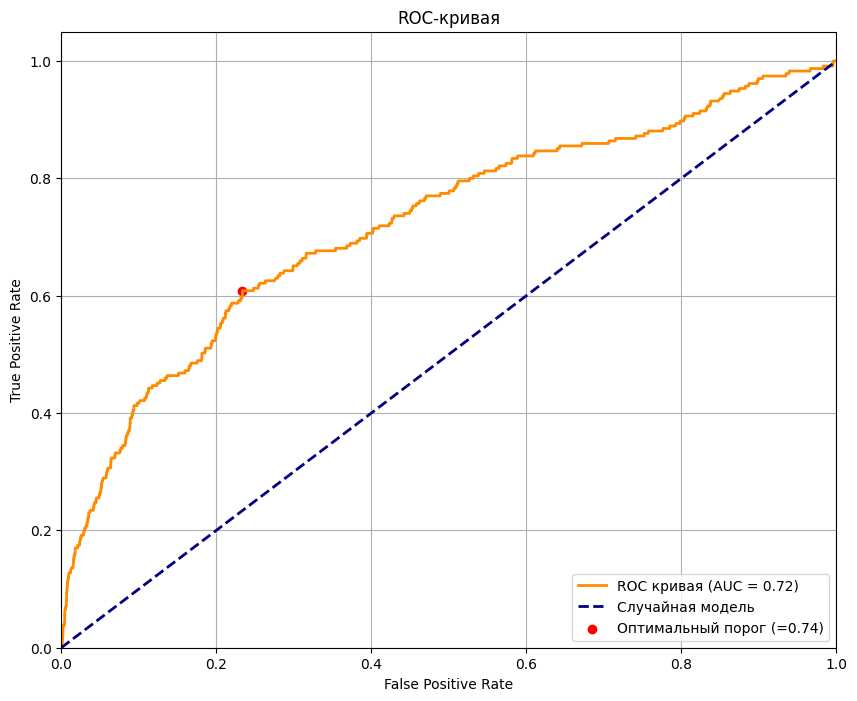


Анализ ROC-AUC (значение = 0.72):
 - Приемлемая разделяющая способность


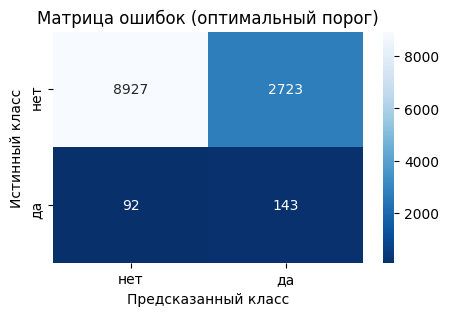


Оптимальный порог классификации: 0.74
Метрики при оптимальном пороге:
 - Accuracy: 0.76
 - Precision: 0.05
 - Recall (TPR): 0.61
 - False Positive Rate: 0.23

Сравнение с порогом 0.5:
 - Accuracy: 0.21
 - Precision: 0.02
 - Recall: 0.90


In [129]:
# получаем предсказанные вероятности и ROC-кривую
y_proba = best_model_class.predict_proba(X_test_transformed)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

# находим оптимальный порог (максимизация TPR - FPR)
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
optimal_y_pred = (y_proba >= optimal_threshold).astype(int)  # Добавлено определение optimal_y_pred

# строим ROC-кривую
plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, color='darkorange', lw=2, 
         label=f'ROC кривая (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Случайная модель')
plt.scatter(fpr[optimal_idx], tpr[optimal_idx], marker='o', color='red', 
            label=f'Оптимальный порог (={optimal_threshold:.2f})')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.legend(loc="lower right")
plt.grid()
plt.show()

# анализ ROC-AUC
print(f"\nАнализ ROC-AUC (значение = {roc_auc:.2f}):")
if roc_auc == 0.5:
    print(" - Модель не лучше случайного угадывания")
elif 0.5 < roc_auc < 0.7:
    print(" - Слабая разделяющая способность")
elif 0.7 <= roc_auc < 0.8:
    print(" - Приемлемая разделяющая способность")
elif 0.8 <= roc_auc < 0.9:
    print(" - Хорошая разделяющая способность")
else:
    print(" - Отличная разделяющая способность")

# матрица ошибок для оптимального порога
plt.figure(figsize=(5, 3))
ax = plt.subplot()
lbls = ['нет', 'да']
cm = confusion_matrix(y_test, optimal_y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
ax.set_xlabel('Предсказанный класс')
ax.set_ylabel('Истинный класс')
ax.set_title('Матрица ошибок (оптимальный порог)')
ax.xaxis.set_ticklabels(lbls)
ax.yaxis.set_ticklabels(lbls)
plt.show()

# метрики для оптимального порога
print(f"\nОптимальный порог классификации: {optimal_threshold:.2f}")
print("Метрики при оптимальном пороге:")
print(f" - Accuracy: {accuracy_score(y_test, optimal_y_pred):.2f}")
print(f" - Precision: {precision_score(y_test, optimal_y_pred, zero_division=0):.2f}")
print(f" - Recall (TPR): {recall_score(y_test, optimal_y_pred, zero_division=0):.2f}")
print(f" - False Positive Rate: {fpr[optimal_idx]:.2f}")

# сравнение с порогом 0.5
y_pred_default = (y_proba >= 0.5).astype(int)
print("\nСравнение с порогом 0.5:")
print(f" - Accuracy: {accuracy_score(y_test, y_pred_default):.2f}")
print(f" - Precision: {precision_score(y_test, y_pred_default, zero_division=0):.2f}")
print(f" - Recall: {recall_score(y_test, y_pred_default, zero_division=0):.2f}")

## Выводы

Проект по прогнозированию бинарного целевого признака с существенным дисбалансом классов (2% положительных случаев) был успешно реализован. На начальном этапе проведен тщательный анализ трех предоставленных датасетов (с информацией о покупках клиентов, рассылках и дополнительными признаками). После предварительного анализа и предобработки данных были сформированы дополнительные признаки для улучшения качества моделирования.

Основные особенности проекта:
1. Для заполнения пропусков была использована модель DecisionTreeClassifier / Regressor.
2. Для оценки важности признаков была испольвана модель RandomForestClassifier.
3. Для решения проблемы сильного дисбаланса классов (2% положительных случаев) применена комбинированная стратегия SMOTETomek, сочетающая синтетическую генерацию примеров миноритарного класса (SMOTE) и очистку данных от шумовых наблюдений (Tomek Links).
4. Учитывая отсутствие сильной линейной зависимости между признаками и целевой переменной, выбор был сделан в пользу ансамблевых методов, показавших лучшие результаты на нелинейных зависимостях.
5. В процессе моделирования тестировались четыре алгоритма: LightGBM, Random Forest, Logistic Regression и SVM, с оптимизацией по метрике ROC-AUC.

Лучший результат показала модель LightGBM со следующими характеристиками:
- ROC-AUC = 72%;
- Оптимальный порог классификации: 0.74;
- Accuracy: 0.74;
- Precision: 0.05;
- Recall: 0.61.

Полученная модель демонстрирует приемлемую предсказательную способность.